In [2]:
from sklearn.metrics import classification_report
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.utils import print_summary
from tensorflow.python.keras.models import Model as KerasModel
from tensorflow.python.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.python.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.python.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import os
import random
random.seed(32)
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2" # Choose GPU NUMBERS [0, 1, 2, 3]
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)
sess.run(tf.global_variables_initializer())

/home/tyler/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        # shear_range=0.2,
        # zoom_range=0.2,
        # horizontal_flip=True
)

validation_datagen = ImageDataGenerator(
        rescale=1./255,
)
train_generator = train_datagen.flow_from_directory(
        'dataset/train',# this is the target directory
        target_size=(256, 256),  # all images will be resized to 150x150
        class_mode='binary',
        shuffle=True,
        seed=32) 
validation_generator = validation_datagen.flow_from_directory(
        'dataset/val',# this is the target directory
        target_size=(256, 256),  # all images will be resized to 150x150
        class_mode='binary',
        shuffle=True,
        seed=32) 

Found 614367 images belonging to 2 classes.
Found 140816 images belonging to 2 classes.


32
[1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1.
 0. 1. 0. 1. 1. 1. 0. 0.]
(32, 256, 256, 3)
[1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1.
 0. 1. 0. 1. 1. 1. 0. 0.]


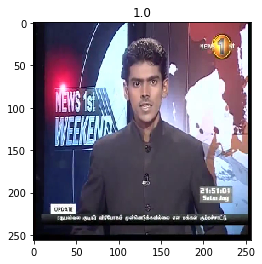

In [4]:
# x=train_generator.__getitem__(0)
# print(len(train_generator.labels),train_generator.labels)
# print(x[1].shape)
# print(x[1])
# plt.imshow(x[0][7])
# plt.title(x[1][7])

# Get a batch of data
x, y = train_generator.next()

# Print the length of labels and the labels themselves
print(len(y))
print(y)

# Print the shape of x[1]
print(x.shape)

# Print the labels
print(y)

# Display an image from the batch with its corresponding label
plt.imshow(x[0])
plt.title(y[0])
plt.show()


In [6]:
def get_pred(predictions):
    pred=[]
    for p in predictions:
        if p<0.50:
             pred.append(0)
        else:
            pred.append(1)
    return pred

IMGWIDTH = 256

class Classifier:
    def __init__(self):
        self.model = 0
    
    def predict(self, x):
        return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    
    def load(self, path):
        self.model.load_weights(path)


class MesoInception4(Classifier):
    # def __init__(self, learning_rate = 0.001):
    def __init__(self, learning_rate=0.001, dropout_rate=0.5):
        self.model = self.init_model(dropout_rate)
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
        
    
    def InceptionLayer(self, a, b, c, d):
        def func(x):
            x1 = Conv2D(a, (1, 1), padding='same', activation='relu')(x)
            
            x2 = Conv2D(b, (1, 1), padding='same', activation='relu')(x)
            x2 = Conv2D(b, (3, 3), padding='same', activation='relu')(x2)
            
            x3 = Conv2D(c, (1, 1), padding='same', activation='relu')(x)
            x3 = Conv2D(c, (3, 3), dilation_rate = 2, strides = 1, padding='same', activation='relu')(x3)
            
            x4 = Conv2D(d, (1, 1), padding='same', activation='relu')(x)
            x4 = Conv2D(d, (3, 3), dilation_rate = 3, strides = 1, padding='same', activation='relu')(x4)

            y = Concatenate(axis = -1)([x1, x2, x3, x4])
            
            return y
        return func
    
    def init_model(self, dropout_rate):
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))
        
        x1 = self.InceptionLayer(1, 4, 4, 2)(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = self.InceptionLayer(2, 4, 4, 2)(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)        
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(dropout_rate)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return KerasModel(inputs = x, outputs = y)

In [7]:
model= MesoInception4().model
model_checkpoint_callback = ModelCheckpoint(
    filepath="MI4_DF_Ebest_new_loss_only.h5",
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)
csv_logger = CSVLogger("MI4_DF_train_new_loss_only.csv", append=True, separator=',')
print_summary(model, line_length=115, positions=None, print_fn=None)

___________________________________________________________________________________________________________________
Layer (type)                         Output Shape              Param #       Connected to                          
input_1 (InputLayer)                 (None, 256, 256, 3)       0                                                   
___________________________________________________________________________________________________________________
conv2d_2 (Conv2D)                    (None, 256, 256, 4)       16            input_1[0][0]                         
___________________________________________________________________________________________________________________
conv2d_4 (Conv2D)                    (None, 256, 256, 4)       16            input_1[0][0]                         
___________________________________________________________________________________________________________________
conv2d_6 (Conv2D)                    (None, 256, 256, 2)       8        

In [7]:
model.fit_generator(train_generator,
                    verbose=2,
                    #changed epochs to 1 to make faster
                    epochs=1,
                    validation_data=validation_generator,
                    callbacks=[model_checkpoint_callback,csv_logger])
model.save_weights("MI4_DF_E50_new_loss_only.h5")

Epoch 1/1


KeyboardInterrupt: 

# DeepFake Test 

In [8]:
test_datagen = ImageDataGenerator(rescale=1./255)
model= MesoInception4()
model.load("MI4_DF_Ebest_new_loss_only.h5")
model=model.model
print_summary(model, line_length=115, positions=None, print_fn=None)
test_generator = test_datagen.flow_from_directory(
        'dataset/testing',# this is the target directory
        target_size=(256, 256),  # all images will be resized to 150x150
        class_mode='binary',
        shuffle=False,
        seed=32) 
predictions=model.evaluate_generator(test_generator)
print(predictions)
predictions=model.predict_generator(test_generator)
predicted_classes = get_pred(predictions)
true_classes = test_generator.classes
report = classification_report(true_classes, predicted_classes, digits=4)
print(report)

___________________________________________________________________________________________________________________
Layer (type)                         Output Shape              Param #       Connected to                          
input_2 (InputLayer)                 (None, 256, 256, 3)       0                                                   
___________________________________________________________________________________________________________________
conv2d_18 (Conv2D)                   (None, 256, 256, 4)       16            input_2[0][0]                         
___________________________________________________________________________________________________________________
conv2d_20 (Conv2D)                   (None, 256, 256, 4)       16            input_2[0][0]                         
___________________________________________________________________________________________________________________
conv2d_22 (Conv2D)                   (None, 256, 256, 2)       8        

KeyboardInterrupt: 

### K-fold Cross Validation

In [4]:
from sklearn.model_selection import cross_val_score

test_datagen = ImageDataGenerator(rescale=1./255)
model= MesoInception4()
model.load("MI4_DF_Ebest_new_loss_only.h5")
model=model.model

test_generator = test_datagen.flow_from_directory(
        'dataset/testing',# this is the target directory
        target_size=(256, 256),  # all images will be resized to 150x150
        class_mode='binary',
        shuffle=False,
        seed=32) 

# Extract data and labels from generator
def extract_data_from_generator(generator):
    data = []
    labels = []
    for i in range(len(generator)):
        batch_data, batch_labels = generator[i]
        data.append(batch_data)
        labels.append(batch_labels)
    data = np.vstack(data)
    labels = np.concatenate(labels)
    return data, labels

x_test, y_test = extract_data_from_generator(test_generator)

cv_scores = cross_val_score(model, x_test, y_test, 
                            cv=10, scoring="accuracy")

Found 100772 images belonging to 2 classes.


: 

In [9]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(learning_rate=0.001, dropout_rate=0.5):
    return MesoInception4(learning_rate=learning_rate, dropout_rate=dropout_rate).model

# Create a KerasClassifier
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define the grid of hyperparameters to search
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout_rate': [0.3, 0.5, 0.7],
    'batch_size': [32, 64, 128],
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# Define your data generators
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(256, 256),
    class_mode='binary',
    shuffle=True,
    seed=32)

validation_generator = validation_datagen.flow_from_directory(
    'dataset/val',
    target_size=(256, 256),
    class_mode='binary',
    shuffle=True,
    seed=32)

# Extract data from generators for GridSearchCV
X_train, y_train = next(train_generator)
X_val, y_val = next(validation_generator)

# Fit the grid search
grid_result = grid.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

best_model = grid_result.best_estimator_.model
best_model.save_weights('best_model_weights.h5')

Found 614367 images belonging to 2 classes.
Found 140816 images belonging to 2 classes.


KeyboardInterrupt: 